In [1]:
import pickle
from misc import *
import SYCLOP_env as syc
from RL_brain_b import DeepQNetwork


In [2]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [3]:
import cv2

In [3]:
from scipy import misc
import glob
datapath='/home/bnapp/arivkindNet/video_datasets/dataset-corridor1_512_16/mav0/cam0/data/'
images=[]
max_image = 2
image_cnt = 0 
for image_path in sorted(glob.glob(datapath+"*.png")):
    images.append( misc.imread(image_path))
    image_cnt += 1
    if image_cnt > max_image:
        break

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


In [4]:
    hp = HP()
    hp.mem_depth=1
    hp.logmode = False
#     recorder = Recorder(n=4)
    images = read_images_from_path('../video_datasets/liron_images/*.jpg')
    images = [np.sum(1.0*uu, axis=2) for uu in images]
    images = [cv2.resize(uu, dsize=(256, 256-64), interpolation=cv2.INTER_AREA) for uu in images]
    scene = syc.Scene(frame_list=images)
    sensor = syc.Sensor()
    agent = syc.Agent(max_q = [scene.maxx-sensor.hp.winx,scene.maxy-sensor.hp.winy])

    reward = syc.Rewards()
    observation_size = 256*4
    RL = DeepQNetwork(len(agent.hp.action_space), observation_size*hp.mem_depth,#sensor.frame_size+2,
                      reward_decay=0.99,
                      e_greedy=0.99,
                      e_greedy0=0.99,
                      replace_target_iter=10,
                      memory_size=100000,
                      e_greedy_increment=0.0001,
                      learning_rate=0.0025,
                      double_q=False,
                      dqn_mode=True,
                      state_table=np.zeros([1,observation_size*hp.mem_depth])
                      )




In [5]:
RL.dqn.load_nwk_param('best_liron.nwk')

In [6]:

def local_observer(sensor,agent):
    if hp.logmode:
        normfactor=1.0
    else:
        normfactor = 1.0/600.0
    # return np.concatenate([1.0/65000*(sensor.dvs_view.reshape([-1]))])
    # return 1.0/65000*np.concatenate([relu_up_and_down(sensor.central_dvs_view),
    #        relu_up_and_down(sensor.dvs_view, downsample_fun=lambda x: cv2.resize(x, dsize=(16, 16), interpolation=cv2.INTER_AREA))])
    return normfactor*np.concatenate([relu_up_and_down(sensor.central_dvs_view),
            relu_up_and_down(cv2.resize(1.0*sensor.dvs_view, dsize=(16, 16), interpolation=cv2.INTER_AREA))])

observation = np.random.uniform(0,1,size=[hp.mem_depth, observation_size])
hp.fading_mem = 0.5

In [7]:
recorders=[]
for image_num,image in enumerate(images):
    recorder = Recorder(n=4)
    step = 0
    episode = 0
    observation = np.random.uniform(0,1,size=[hp.mem_depth, observation_size])
    observation_ = np.random.uniform(0,1,size=[hp.mem_depth, observation_size])
    scene.current_frame = image_num
    scene.image = scene.frame_list[scene.current_frame]

    agent.reset()
    agent.q_ana[1]=256./2.-32
    agent.q_ana[0]=192./2-32
    agent.q = np.int32(np.floor(agent.q_ana))

    sensor.reset()
    sensor.update(scene, agent)
    sensor.update(scene, agent)
    for step_prime in range(1000):
        action = RL.choose_action(observation.reshape([-1]))
        reward.update_rewards(sensor = sensor, agent = agent)
        recorder.record([agent.q_ana[0],agent.q_ana[1],reward.reward,RL.epsilon])
        agent.act(action)
        sensor.update(scene,agent)
        observation *= hp.fading_mem
        observation += local_observer(sensor, agent)  # todo: generalize
        if step%1000 ==0:
            print(episode,step)
#                 print('frame:', scene.current_frame)
        step += 1
    recorders.append(recorder)



0 0
0 0
0 0
0 0
0 0


<IPython.core.display.Javascript object>


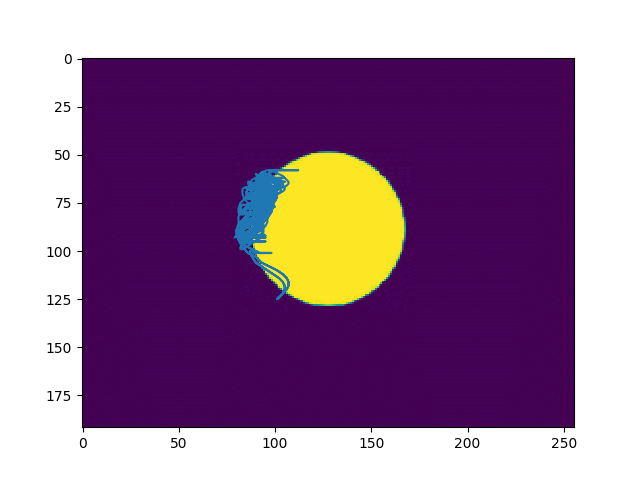

<IPython.core.display.Javascript object>


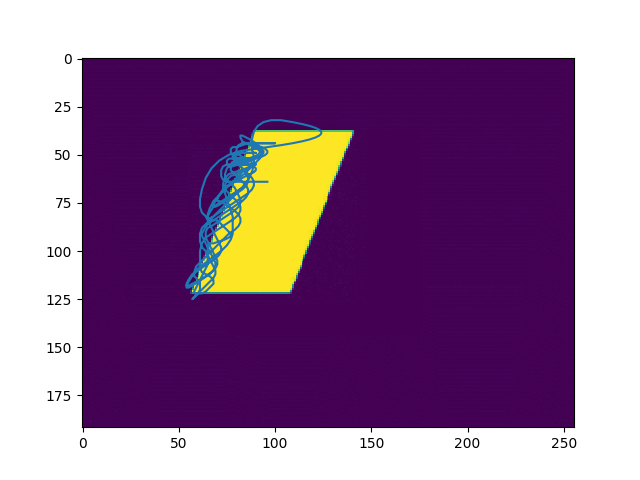

<IPython.core.display.Javascript object>


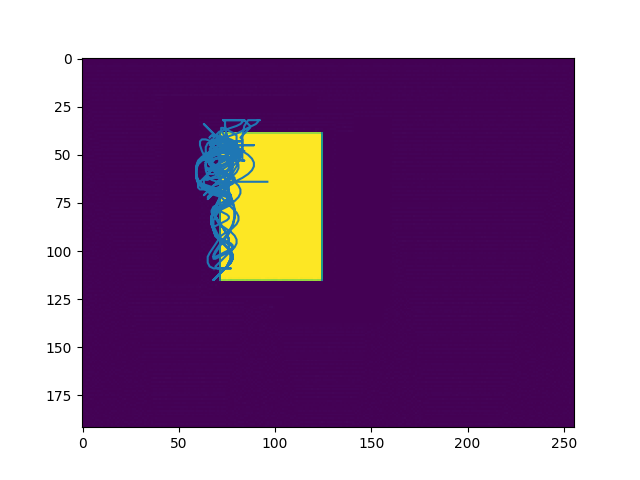

<IPython.core.display.Javascript object>


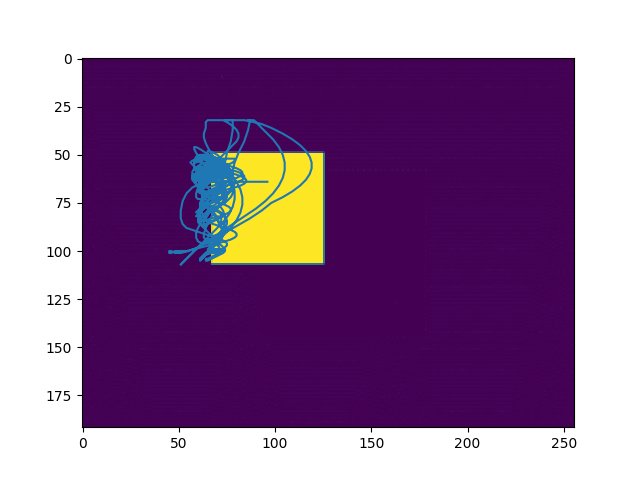

<IPython.core.display.Javascript object>


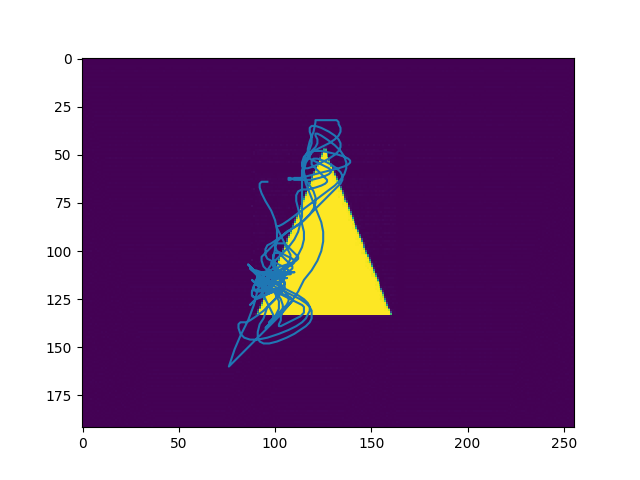

In [9]:
for image,recorder in zip(images,recorders):
    plt.figure()
    plt.imshow(image)
    plt.plot(32+np.array(recorder.records[0]),256-64-32-np.array(recorder.records[1]),'-')

# plt.title('10 syclop trajectories 10,000 timesteps each')

<IPython.core.display.Javascript object>


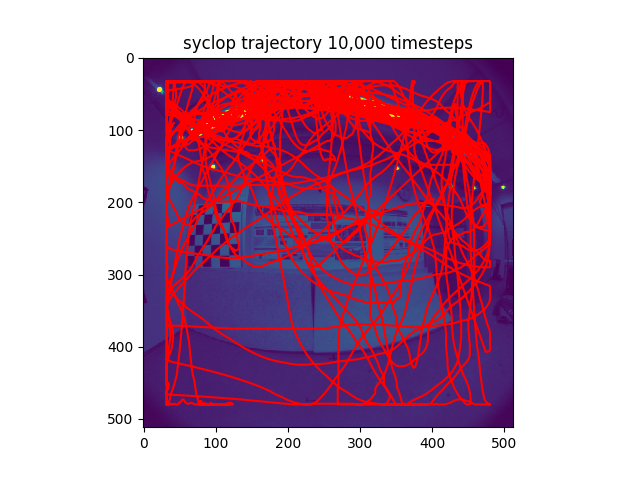

Text(0.5, 1.0, 'syclop trajectory 10,000 timesteps')

In [47]:
plt.figure()
plt.imshow(images[0])
plt.plot(32+np.array(polarec.records[0][-10000:]),512-32-np.array(polarec.records[1][-10000:]),'r-')
# plt.plot(polarec.records[0][-10000:],polarec.records[1][-10000:],'.')
plt.title('syclop trajectory 10,000 timesteps')

In [36]:
vert_edge_image = np.zeros([512,512])
vert_edge_image[:,256:]=64000

vert_edgeB_image = np.zeros([512,512])
vert_edgeB_image[:,:256]=64000

horiz_edge_image = np.zeros([512,512])
horiz_edge_image[256:,:]=64000

patch_image = np.zeros([512,512])
patch_image[200:300,200:300]=64000

patch_image2 = np.zeros([512,512])
patch_image2[50:512-50,50:512-50]=64000

In [37]:
#     scene = syc.Scene(frame_list=another_image)
#     scene = syc.Scene(frame_list=images)
    scene = syc.Scene(frame_list=[patch_image2])


<IPython.core.display.Javascript object>


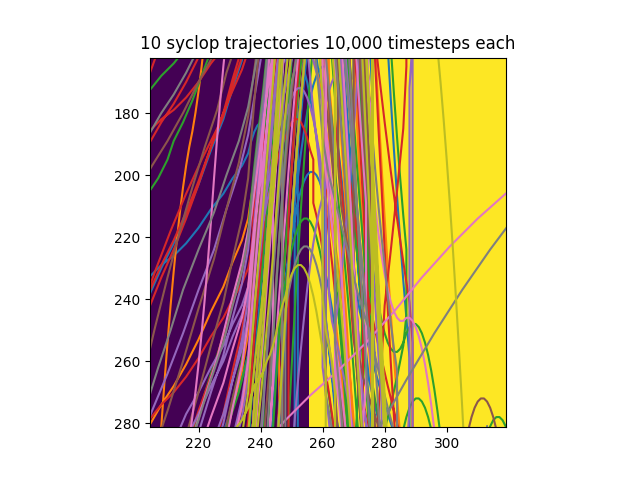

Text(0.5, 1.0, '10 syclop trajectories 10,000 timesteps each')

In [64]:
plt.figure()
plt.imshow(vert_edge_image)
# plt.plot(32+np.array(recorder.records[0][-100000:]),512-32-np.array(recorder.records[1][-100000:]),'r-')
for q in range(1,10):
    plt.plot(32+np.array(recorder.records[0][-10000*q:(-10000*(q-1)-1)]),512-32-np.array(recorder.records[1][-10000*q:(-10000*(q-1)-1)]),'-')

plt.title('10 syclop trajectories 10,000 timesteps each')

<IPython.core.display.Javascript object>


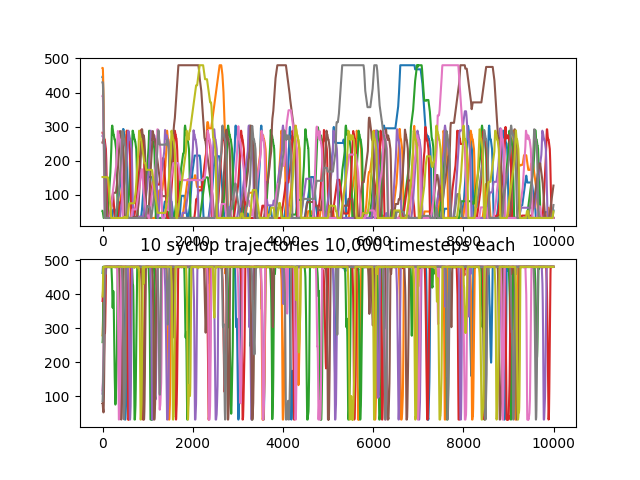

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Text(0.5, 1.0, '10 syclop trajectories 10,000 timesteps each')

In [66]:
plt.figure()
# plt.plot(32+np.array(recorder.records[0][-100000:]),512-32-np.array(recorder.records[1][-100000:]),'r-')
for q in range(1,10):
    plt.subplot(2,1,1)
    plt.plot(32+np.array(recorder.records[0][-10000*q:(-10000*(q-1)-1)]),'-')
    plt.subplot(2,1,2)
    
    plt.plot(512-32-np.array(recorder.records[1][-10000*q:(-10000*(q-1)-1)]),'-')

plt.title('10 syclop trajectories 10,000 timesteps each')

<IPython.core.display.Javascript object>


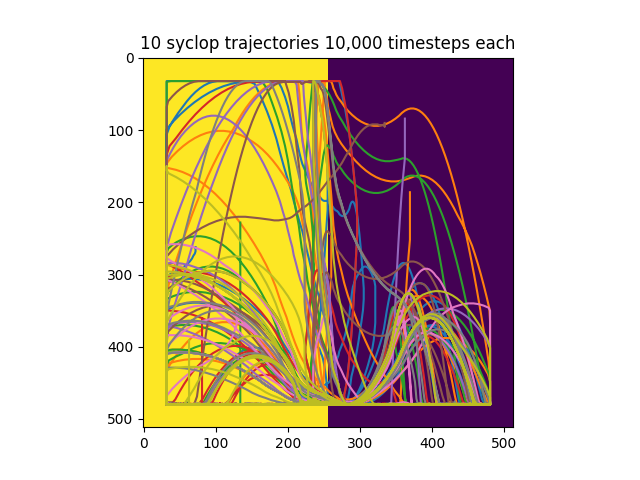

Text(0.5, 1.0, '10 syclop trajectories 10,000 timesteps each')

In [71]:
plt.figure()
plt.imshow(vert_edgeB_image)
# plt.plot(32+np.array(recorder.records[0][-100000:]),512-32-np.array(recorder.records[1][-100000:]),'r-')
for q in range(1,10):
    plt.plot(32+np.array(recorder.records[0][-10000*q:(-10000*(q-1)-1)]),512-32-np.array(recorder.records[1][-10000*q:(-10000*(q-1)-1)]),'-')

plt.title('10 syclop trajectories 10,000 timesteps each')

<IPython.core.display.Javascript object>


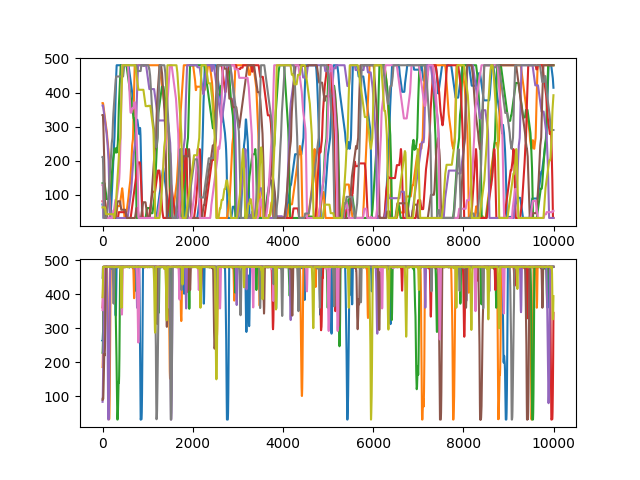

In [72]:
plt.figure()
# plt.plot(32+np.array(recorder.records[0][-100000:]),512-32-np.array(recorder.records[1][-100000:]),'r-')
for q in range(1,10):
    plt.subplot(2,1,1)
    plt.plot(32+np.array(recorder.records[0][-10000*q:(-10000*(q-1)-1)]),'-')
    plt.subplot(2,1,2)
    
    plt.plot(512-32-np.array(recorder.records[1][-10000*q:(-10000*(q-1)-1)]),'-')

In [7]:
MM=int(np.max(polarec.records[0]))

In [8]:
heatmap=np.zeros([64+MM+1,64+MM+1])

In [9]:
for x,y in zip(polarec.records[0][-1000000:],polarec.records[1][-1000000:]):
    heatmap[64+MM-int(32+y),int(32+x)] +=1

<IPython.core.display.Javascript object>


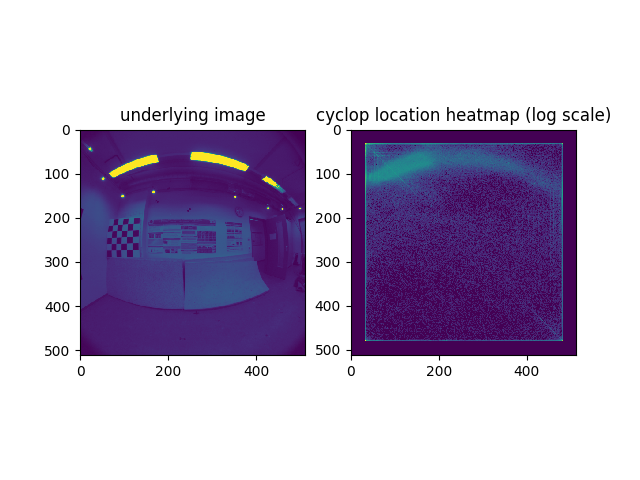

Text(0.5, 1.0, 'cyclop location heatmap (log scale)')

In [10]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(images[0])
plt.title('underlying image')
# plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(np.log10(heatmap+1))
plt.title('cyclop location heatmap (log scale)')



<IPython.core.display.Javascript object>


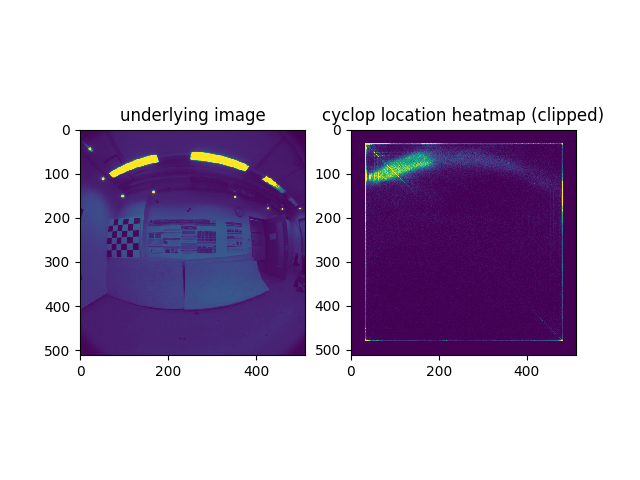

Text(0.5, 1.0, 'cyclop location heatmap (clipped)')

In [11]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(images[0])
# plt.ylim([0,100])
plt.title('underlying image')
# plt.colorbar()
plt.subplot(1,2,2)
plt.imshow((np.minimum(heatmap+1,100)))
# plt.ylim([0,100])
plt.title('cyclop location heatmap (clipped)')